In [148]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
colab_path = '/content/drive/MyDrive/ColabNotebooks/airplane'

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet(colab_path + '/train.csv', 'train')
csv_to_parquet(colab_path + '/test.csv', 'test')

train Done.
test Done.


In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv(colab_path + '/sample_submission.csv', index_col = 0)

##**데이터 파악하기**

In [ ]:
train.shape # 데이터셋의 형태를 확인

(1000000, 19)

In [ ]:
train.info() # 컬럼명, 데이터타입을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
train.describe() #데이터셋의 수치형 컬럼별 주요 통계량을 summary

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
train.isnull().sum() #결측값 확인

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
#각 열별 결측치의 비율
print(train.isnull().sum()/len(train) * 100)

ID                           0.0000
Month                        0.0000
Day_of_Month                 0.0000
Estimated_Departure_Time    10.9019
Estimated_Arrival_Time      10.9040
Cancelled                    0.0000
Diverted                     0.0000
Origin_Airport               0.0000
Origin_Airport_ID            0.0000
Origin_State                10.9015
Destination_Airport          0.0000
Destination_Airport_ID       0.0000
Destination_State           10.9079
Distance                     0.0000
Airline                     10.8920
Carrier_Code(IATA)          10.8990
Carrier_ID(DOT)             10.8997
Tail_Number                  0.0000
Delay                       74.4999
dtype: float64


In [ ]:
# 각 열의 고유값의 수
train.nunique()

ID                          1000000
Month                            12
Day_of_Month                     31
Estimated_Departure_Time       1365
Estimated_Arrival_Time         1428
Cancelled                         1
Diverted                          1
Origin_Airport                  374
Origin_Airport_ID               374
Origin_State                     52
Destination_Airport             375
Destination_Airport_ID          375
Destination_State                52
Distance                       1597
Airline                          28
Carrier_Code(IATA)               11
Carrier_ID(DOT)                  28
Tail_Number                    6430
Delay                             2
dtype: int64

In [ ]:
train['Destination_State'].value_counts() # 특정 열의 값 개수, 디폴트  내림차순

California                                        104347
Texas                                              87950
Florida                                            66474
Illinois                                           58323
New York                                           44144
Georgia                                            41620
Colorado                                           39490
North Carolina                                     35089
Virginia                                           34272
Washington                                         25666
Nevada                                             23661
Pennsylvania                                       23660
Michigan                                           22452
Arizona                                            22448
New Jersey                                         21910
Massachusetts                                      18189
Missouri                                           17212
Minnesota                      

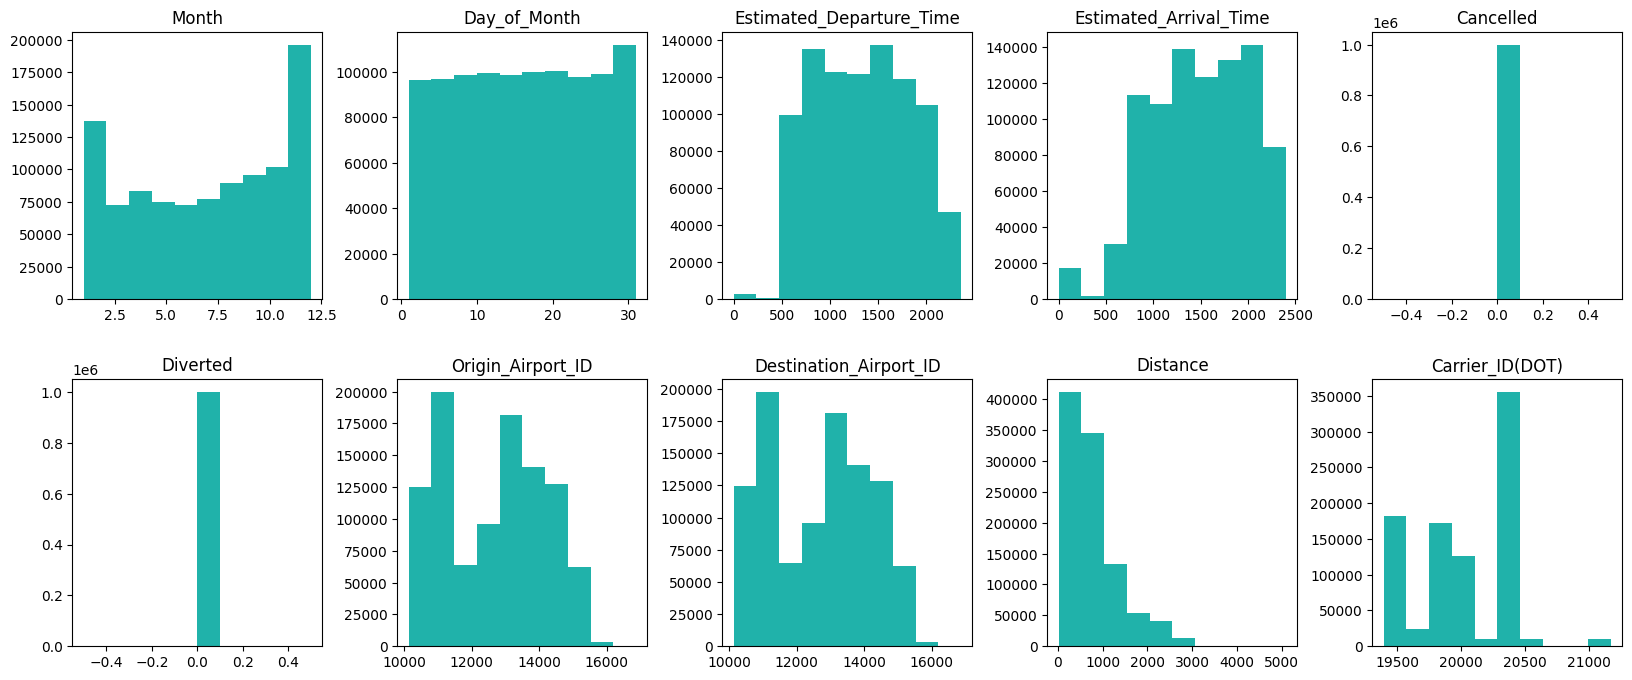

In [ ]:
train.hist(bins = 10 , layout = (4,5), figsize = (20,17)  ,column = train.columns[1:], color= "LightSeaGreen", grid = False)
plt.show()

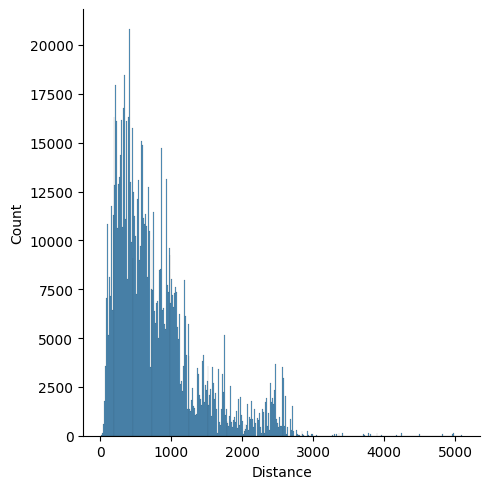

In [182]:
# 수치형 데이터 분포 확인
sns.displot(train['Distance'])

In [ ]:
!pip install plotly.express

In [ ]:
import plotly.express as px
fig = px.scatter(train, x="Day_of_Month", y="Distance", 
                 color = "Delay", 
                 facet_col = "Month")
fig.show()

In [ ]:
my_data=['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']
len(my_data)

7

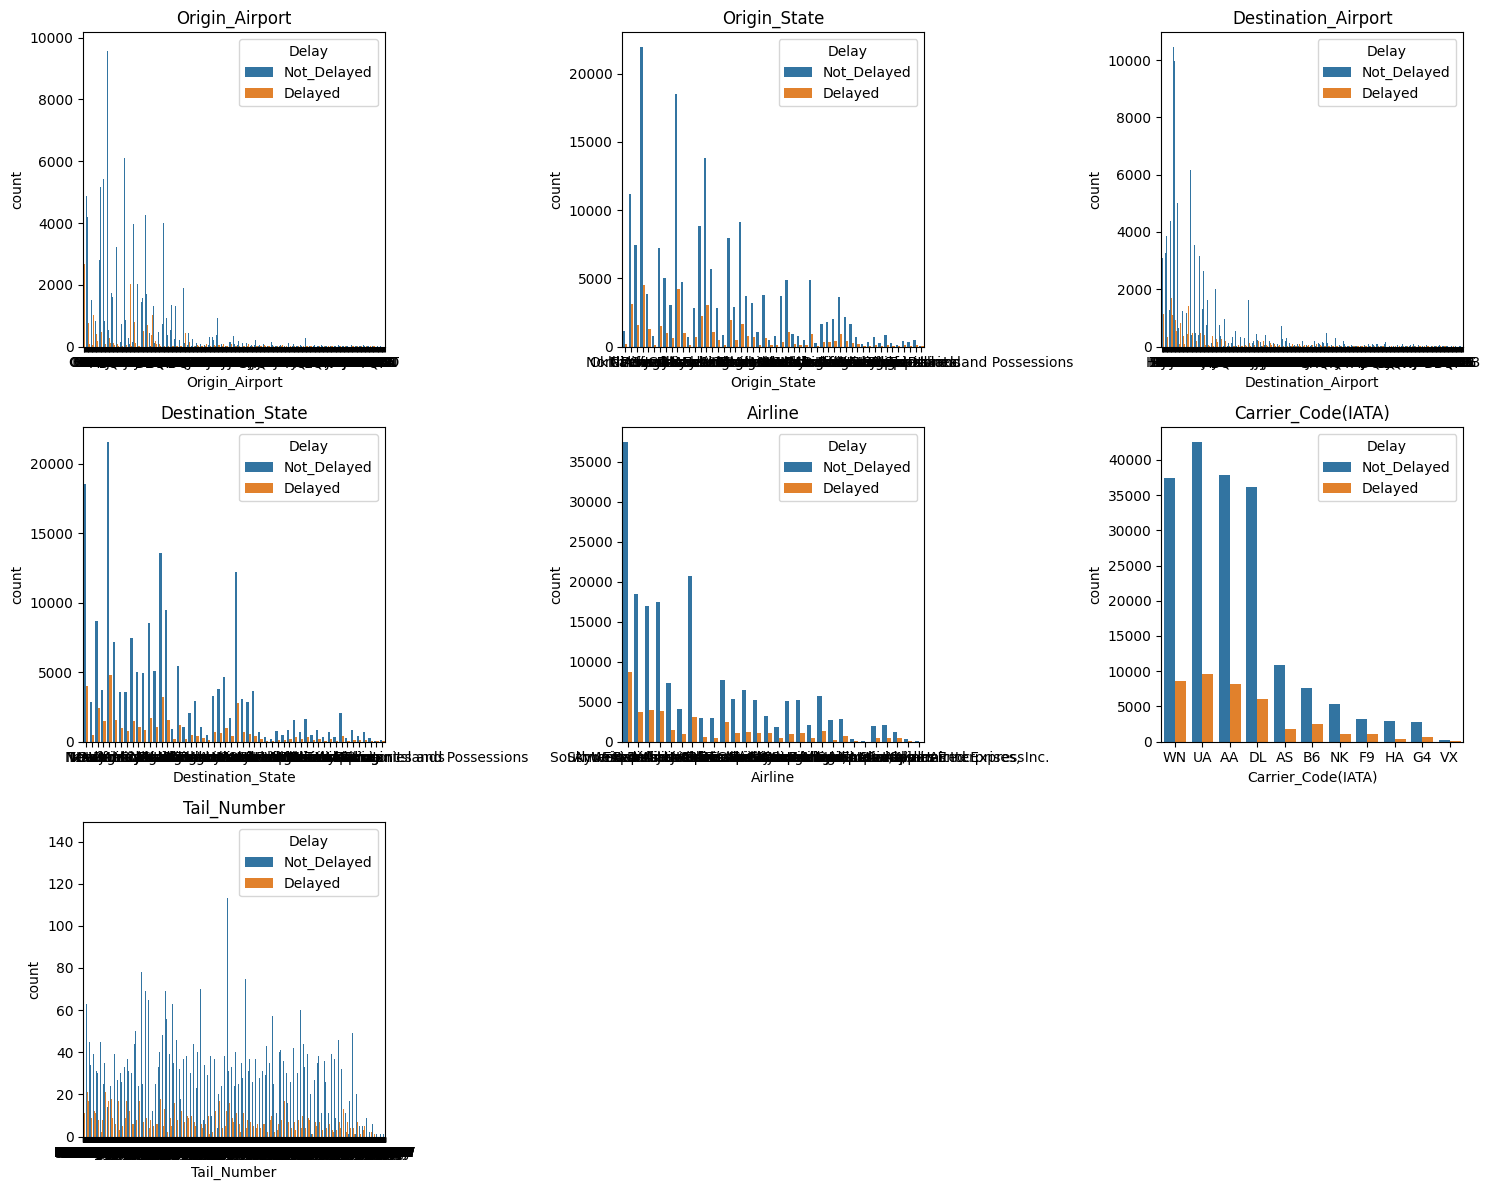

In [ ]:
plt.figure(figsize=(15,12))
for i in range(len(my_data)):
    plt.subplot(3,3,i+1)
    plt.title(my_data[i])
    sns.countplot(x=train[my_data[i]],hue=train['Delay'])    
plt.tight_layout()

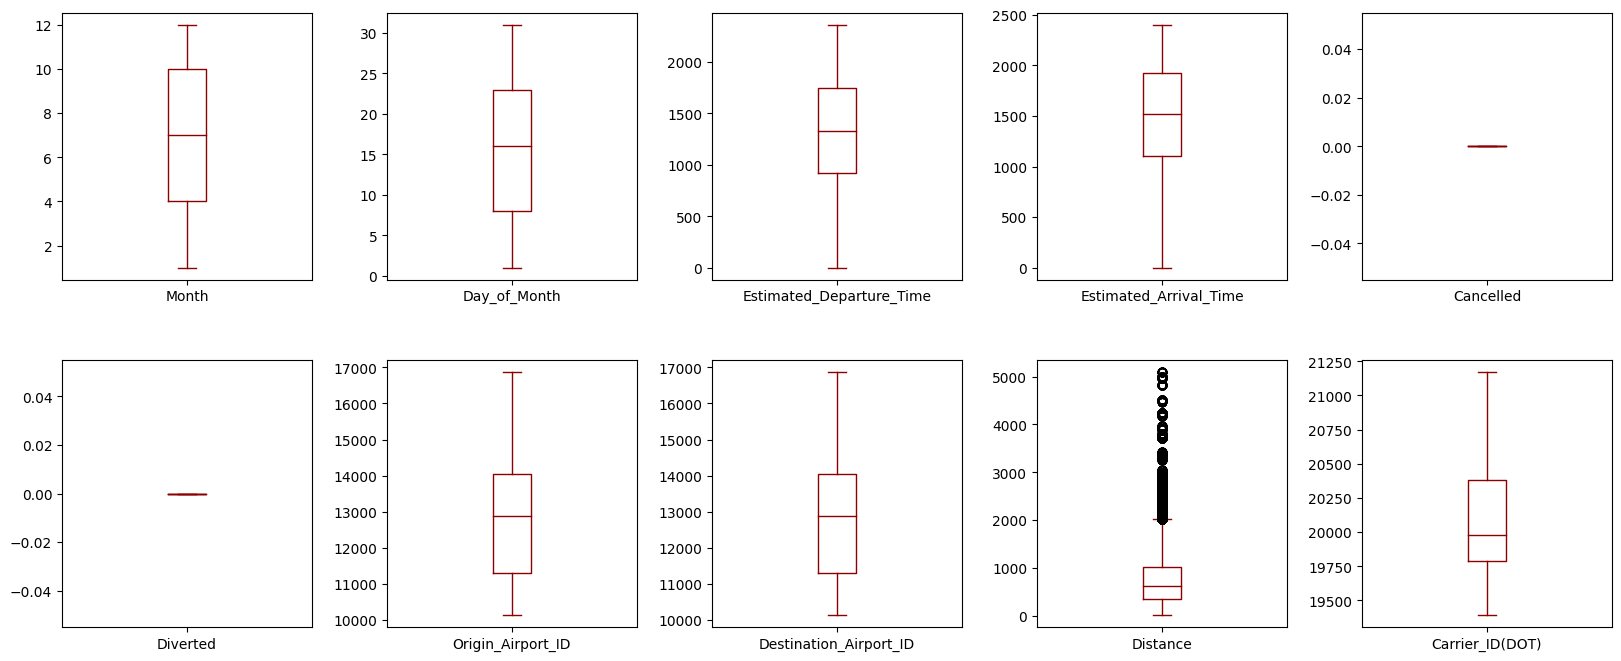

In [ ]:
train.plot(subplots =True, kind = 'box', layout = (4,5), figsize = (20,17), color = 'DarkRed')
plt.subplots_adjust(wspace = 0.3, hspace= 0.3)

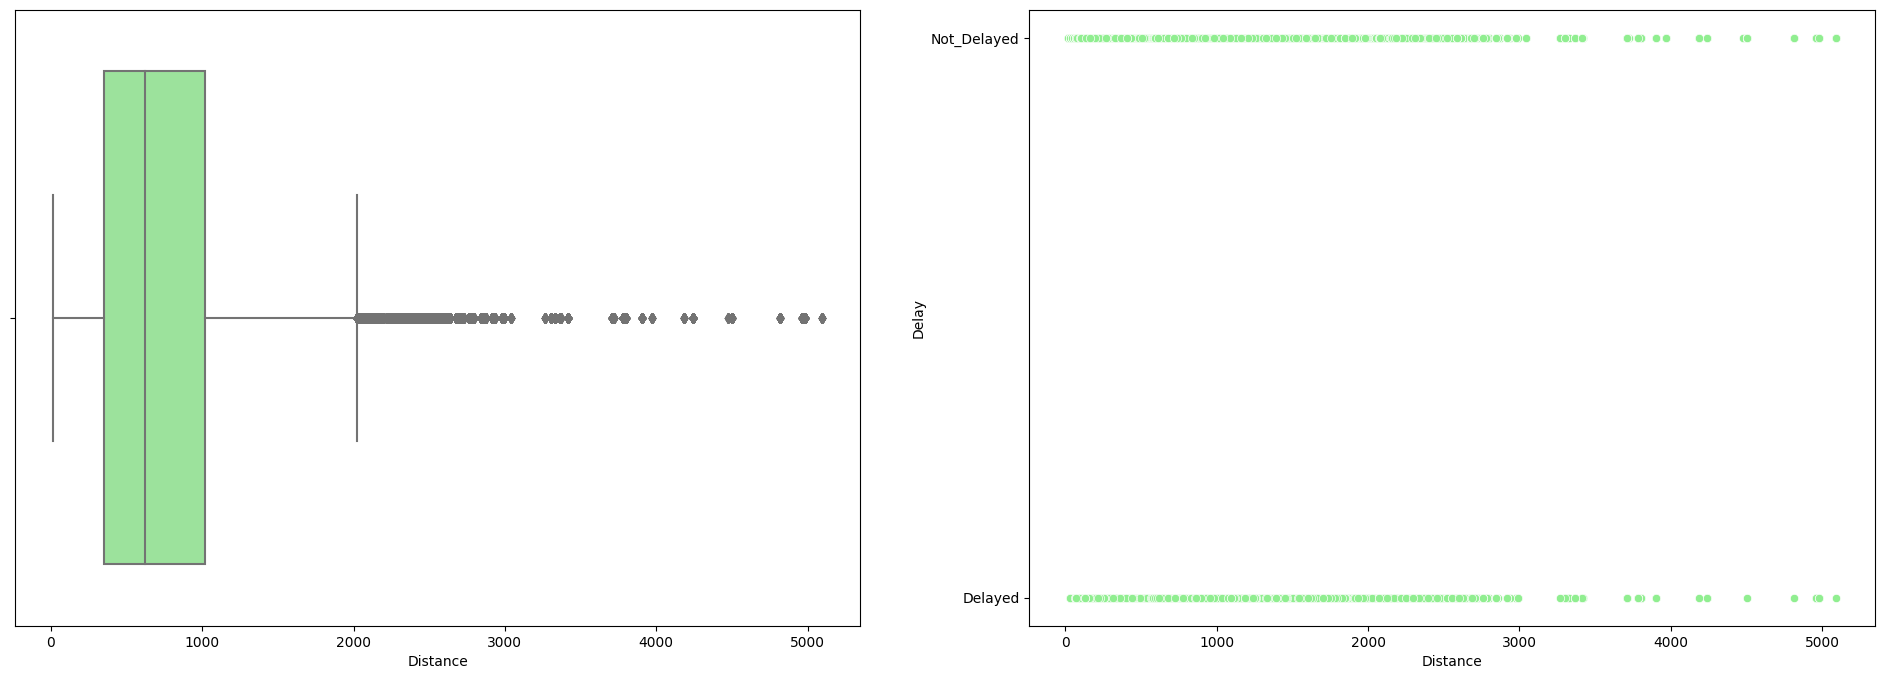

In [176]:
#Outliers preprocessing
def comp(data, col, color):
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1) #to make the 2 graphs next to each other
    sns.boxplot(data = train,x=col, color = color )
    plt.subplot(1,2,2) #to make the 2 graphs next to each other
    sns.scatterplot(x=train[col],y=train['Delay'], color = color)
    
comp(train, 'Distance','lightgreen')


In [177]:
train[train['Distance']>=2000].shape

(57158, 19)

<ipython-input-35-224f1e9711df>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



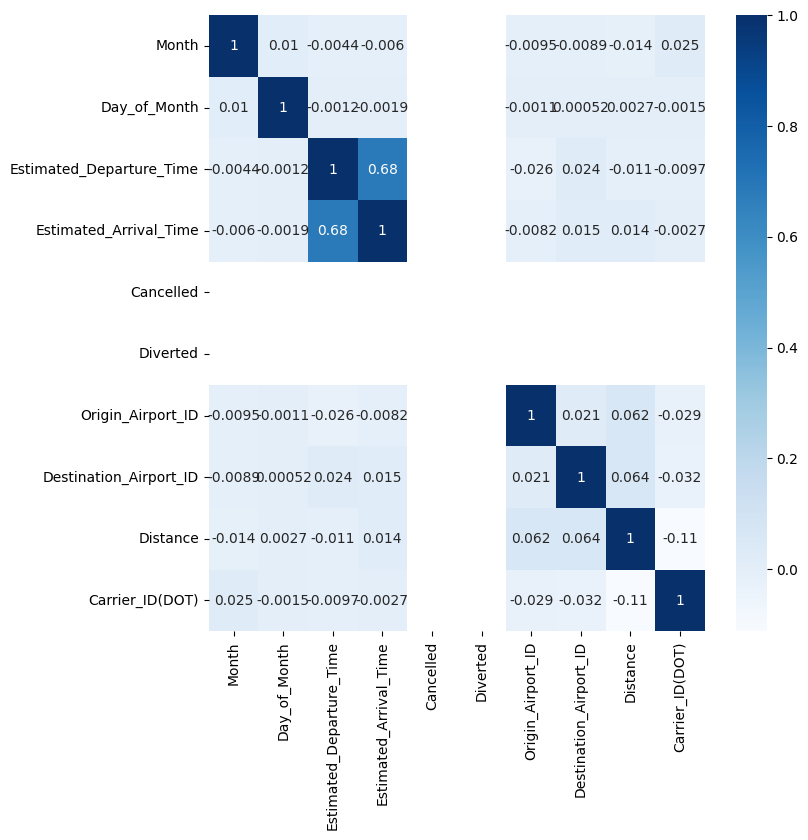

In [ ]:
# 히트맵으로 상관관계 표시
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [ ]:
target= train['Delay'].value_counts().reset_index() #타겟변수의 데이터 확인
target


,index,Delay
0,Not_Delayed,210001
1,Delayed,45000


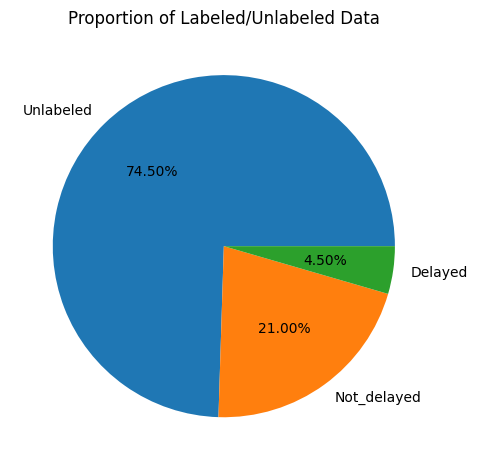

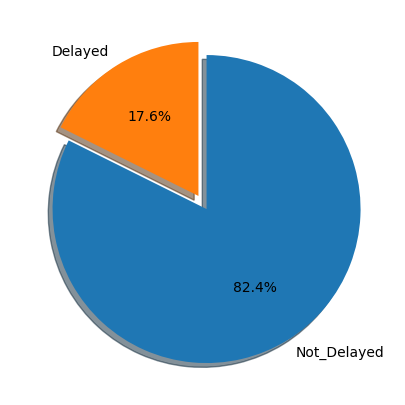

In [ ]:
unlabeled_delay_value = train.Delay.isnull().sum()

not_delay_value = train.loc[train.Delay == 'Not_Delayed'].shape[0]
delay_value = train.loc[train.Delay == 'Delayed'].shape[0]

labels = ['Unlabeled', 'Not_delayed', 'Delayed']
sizes = [unlabeled_delay_value, not_delay_value, delay_value]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Proportion of Labeled/Unlabeled Data')
plt.tight_layout()

explode = [0.05] * 2

plt.figure(figsize = (10, 5))
plt.pie(target['Delay'], labels = target['index'], autopct = '%.1f%%', startangle = 90, counterclock = False,shadow = True, explode = explode)
plt.show()



<Axes: xlabel='Day_of_Month', ylabel='count'>

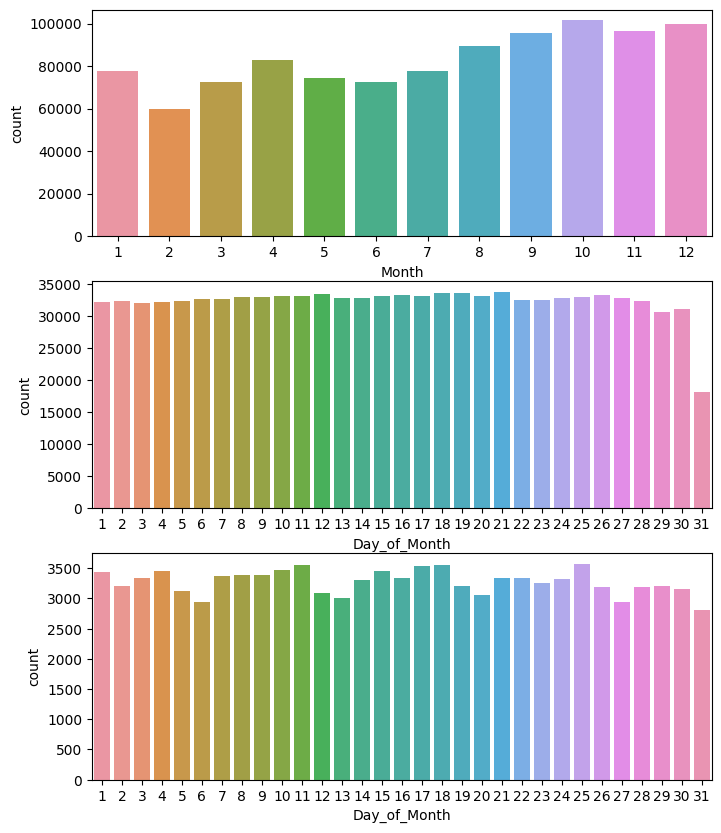

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
sns.countplot(x = 'Month', data = train) #월별 항공편
plt.subplot(3,1,2)
sns.countplot(x = 'Day_of_Month', data = train) #일별 항공편

tr = train[train['Month']==10] #10월 추출
plt.subplot(3,1,3)
sns.countplot(x = 'Day_of_Month', data = tr) #10월의 일별 항공편

## **결측값 처리**

In [ ]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들을 데이터의 최빈값으로 대체합니다
NaN_col = ['Origin_State','Destination_State','Airline','Estimated_Departure_Time', 'Estimated_Arrival_Time','Carrier_Code(IATA)','Carrier_ID(DOT)']

for col in NaN_col:
    mode = train[col].mode()[0]
    mode1 = test[col].mode()[0]
    train[col] = train[col].fillna(mode)
    
    if col in test.columns:
        test[col] = test[col].fillna(mode1)
print('Done.')

Done.


In [ ]:
traind = train.dropna() #결측치가 존재하는 모든 데이터행을 제거

In [ ]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들의 데이터를 제거
#NaN_col = ['Origin_State','Destination_State','Airline','Estimated_Departure_Time', 'Estimated_Arrival_Time','Carrier_Code(IATA)','Carrier_ID(DOT)']

#train.dropna(subset=NaN_col, inplace=True)
#test.dropna(subset=NaN_col, inplace=True)

#print('Done.')

Done.


In [ ]:
train.isnull().sum() #결측값 확인

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                0
Distance                         0
Airline                          0
Carrier_Code(IATA)               0
Carrier_ID(DOT)                  0
Tail_Number                      0
Delay                       744999
dtype: int64

## 라벨인코더

In [ ]:
#질적 변수들을 라벨인코더를 활용해 수치화합니다
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('Done.')

Done.


In [ ]:
traind = train.drop(['Cancelled','Diverted'], axis=1) #의미없는 열 제거
testd = test.drop(['Cancelled','Diverted'], axis=1) #의미없는 열 제거

In [ ]:
traind['Delay'] = traind['Delay'].replace({'Not_Delayed': 0, 'Delayed': 1})

In [ ]:
train_x = traind.drop(columns=['ID'])
#y = traind['Delay']
test_x = testd.drop(columns=['ID'])

In [ ]:
# 레이블이 있는 데이터와 없는 데이터로 분리
labeled_data = train_x[train_x['Delay'].notna()]
unlabeled_data = train_x[train_x['Delay'].isna()]

In [ ]:
# 레이블이 있는 데이터에서 X, y 분리
X_train_labeled = labeled_data.drop('Delay', axis=1)
y_train_labeled = labeled_data['Delay']

# 레이블이 없는 데이터에서 X 추출
X_train_unlabeled = unlabeled_data.drop('Delay', axis=1)
y_train_unlabeled = pd.Series(np.zeros(len(X_train_unlabeled))) # 초기값으로 0을 사용합니다.

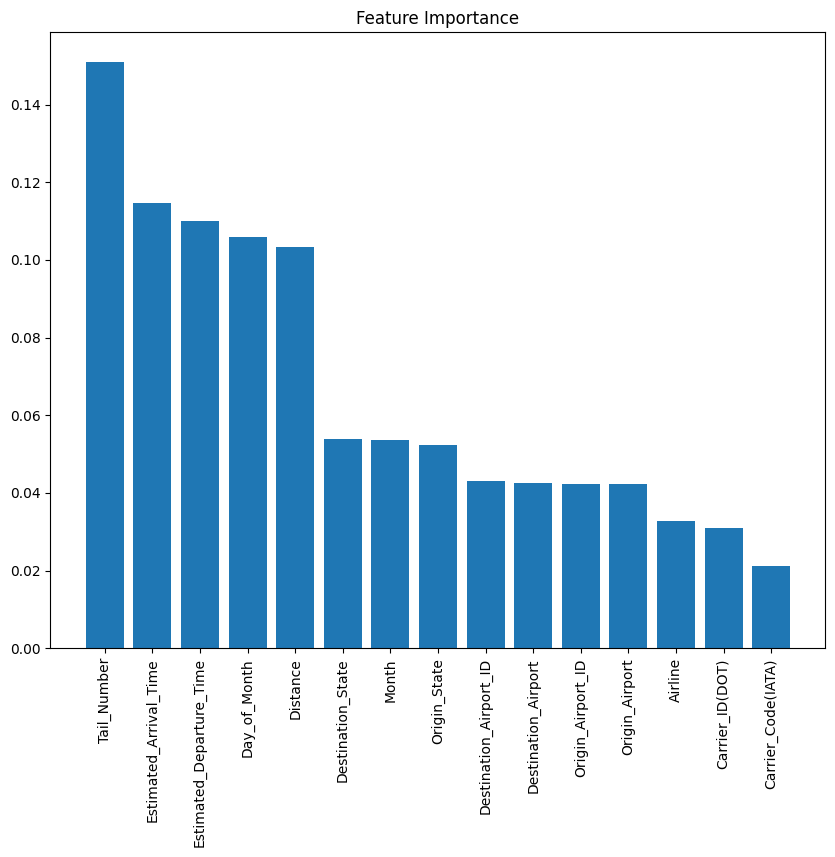

In [187]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train_labeled, y_train_labeled)
# 변수 중요도 계산
importances = model.feature_importances_

# 변수명
feature_names = list(X_train_labeled.columns)

# 중요도 내림차순 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train_labeled.shape[1]), importances[indices])
plt.xticks(range(X_train_labeled.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score


In [ ]:
# 반복 횟수
n_iterations = 100

# 모델 객체 생성
model_1 = GaussianNB()
model_2 = DecisionTreeClassifier(max_depth=5)

# 반복문을 통해 Co-training 알고리즘 수행
for i in range(n_iterations):
    print(f"Iteration {i+1}:")

    # Model 1에 대한 레이블된 데이터셋으로 학습
    model_1.fit(X_train_labeled, y_train_labeled)

    # Model 2에 대한 레이블된 데이터셋으로 학습
    model_2.fit(X_train_labeled, y_train_labeled)

    # Model 1에 대한 예측 결과 중에서 가장 확률이 높은 클래스 추출
    y_pred_1_unlabeled = model_1.predict_proba(X_train_unlabeled)
    y_pred_1_unlabeled = np.argmax(y_pred_1_unlabeled, axis=1)

    # Model 2에 대한 예측 결과 중에서 가장 확률이 높은 클래스 추출
    y_pred_2_unlabeled = model_2.predict_proba(X_train_unlabeled)
    y_pred_2_unlabeled = np.argmax(y_pred_2_unlabeled, axis=1)

    # 모델 간에 서로 다른 예측을 한 데이터 포인트들을 찾기 위해 조건문 사용
    mask_1 = y_pred_1_unlabeled != y_train_unlabeled
    mask_2 = y_pred_2_unlabeled != y_train_unlabeled

    # 예측이 일치하는 데이터 포인트들 중에서 어느 한 모델이 예측을 하나만 했을 때, 다른 모델의 예측을 이용하여 해당 데이터 포인트 레이블링
    idx = np.logical_and(mask_1, mask_2)
    idx_1 = np.logical_and(idx, y_pred_1_unlabeled == y_pred_2_unlabeled)
    idx_2 = np.logical_and(idx, y_pred_1_unlabeled != y_pred_2_unlabeled)

    y_train_unlabeled_1 = y_pred_1_unlabeled.copy()
    y_train_unlabeled_2 = y_pred_2_unlabeled.copy()

    y_train_unlabeled_1[idx_2] = -1
    y_train_unlabeled_2[idx_1] = -1

    # 레이블이 존재하는 데이터셋과 존재하지 않는 데이터셋을 합치기
    X_train_combined = pd.concat([X_train_labeled, X_train_unlabeled])
    y_train_combined_1 = np.concatenate([y_train_labeled.values, y_train_unlabeled_1])
    y_train_combined_2 = np.concatenate([y_train_labeled.values, y_train_unlabeled_2])

# -1로 마킹된 데이터 포인트를 제외하고 모델 학습에 사용할 레이블된 데이터셋 추출
X_train_labeled_1 = X_train_combined[y_train_combined_1 != -1]
y_train_labeled_1 = y_train_combined_1[y_train_combined_1 != -1]
X_train_labeled_2 = X_train_combined[y_train_combined_2 != -1]
y_train_labeled_2 = y_train_combined_2[y_train_combined_2 != -1]





Iteration 1:
Iteration 2:
Iteration 3:
Iteration 4:
Iteration 5:
Iteration 6:
Iteration 7:
Iteration 8:
Iteration 9:
Iteration 10:
Iteration 11:
Iteration 12:
Iteration 13:
Iteration 14:
Iteration 15:
Iteration 16:
Iteration 17:
Iteration 18:
Iteration 19:
Iteration 20:
Iteration 21:
Iteration 22:
Iteration 23:
Iteration 24:
Iteration 25:
Iteration 26:
Iteration 27:
Iteration 28:
Iteration 29:
Iteration 30:
Iteration 31:
Iteration 32:
Iteration 33:
Iteration 34:
Iteration 35:
Iteration 36:
Iteration 37:
Iteration 38:
Iteration 39:
Iteration 40:
Iteration 41:
Iteration 42:
Iteration 43:
Iteration 44:
Iteration 45:
Iteration 46:
Iteration 47:
Iteration 48:
Iteration 49:
Iteration 50:
Iteration 51:
Iteration 52:
Iteration 53:
Iteration 54:
Iteration 55:
Iteration 56:
Iteration 57:
Iteration 58:
Iteration 59:
Iteration 60:
Iteration 61:
Iteration 62:
Iteration 63:
Iteration 64:
Iteration 65:
Iteration 66:
Iteration 67:
Iteration 68:
Iteration 69:
Iteration 70:
Iteration 71:
Iteration 72:
I

In [154]:
# 각 모델에 대해 최종 학습을 수행하고 테스트 데이터셋으로 평가
model_1.fit(X_train_labeled_1, y_train_labeled_1)
model_2.fit(X_train_labeled_2, y_train_labeled_2)

y_pred_1 = model_1.predict_proba(test_x)
y_pred_2 = model_2.predict_proba(test_x)



In [170]:
y_pred = np.maximum(y_pred_1, y_pred_2)
y_pred1 = np.minimum(y_pred_1, y_pred_2)

In [171]:
# 예측 확률 값 및 분류 결과 출력
print("Ensemble Predictions:")
print(y_pred)
# 예측 확률 값 및 분류 결과 출력
print("Ensemble Predictions:")
print(y_pred1)

Ensemble Predictions:
[[0.94950346 0.05113291]
 [0.95593797 0.04489559]
 [0.9537779  0.06004548]
 ...
 [0.93842545 0.06187662]
 [0.96246993 0.05687204]
 [0.96192846 0.03920621]]
Ensemble Predictions:
[[0.94886709 0.05049654]
 [0.95510441 0.04406203]
 [0.93995452 0.0462221 ]
 ...
 [0.93812338 0.06157455]
 [0.94312796 0.03753007]
 [0.96079379 0.03807154]]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# 정확도 계산
accuracy_1 = accuracy_score(test_y, y_test_pred_1)
accuracy_2 = accuracy_score(test_y, y_test_pred_2)

# F1-score 계산
f1_score_1 = f1_score(test_y, y_test_pred_1)
f1_score_2 = f1_score(test_y, y_test_pred_2)

# 오차 행렬(confusion matrix) 시각화
conf_matrix_1 = confusion_matrix(test_y, y_test_pred_1)
conf_matrix_2 = confusion_matrix(test_y, y_test_pred_2)

print("Model 1 accuracy: {:.4f}".format(accuracy_1))
print("Model 1 F1-score: {:.4f}".format(f1_score_1))
print("Model 1 confusion matrix:\n", conf_matrix_1)

print("Model 2 accuracy: {:.4f}".format(accuracy_2))
print("Model 2 F1-score: {:.4f}".format(f1_score_2))
print("Model 2 confusion matrix:\n", conf_matrix_2)

In [174]:
submission = pd.DataFrame(data=y_pred1, columns=sample_submission.columns, index=sample_submission.index)

In [175]:
submission.to_csv('20_submission.csv', index=True)

In [ ]:
df = train[train['Distance']<2000]
df.shape

(942842, 19)